This notebook is completely reusable, simply change the inputs in the 2nd cell to whichever ticker and time period you would like.

The primary purpose of this notebook is to look for correlation between the quantity of Retweets containing the chosen tickerSymbol and the daily trading volume.

In [171]:
import yfinance as yf
import GetOldTweets3 as got
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import statsmodels.api as sm

Input ticker and time period

In [111]:
tickerSymbol = 'RCL'
start = '2020-01-01'
end = '2020-06-14'
#these are the only inputs

In [112]:
# here is yfinance doing its thing
tickerData = yf.Ticker(tickerSymbol)
ticker_df = tickerData.history(period='1d', start=start, end=end)
ticker_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-01-02,133.23,133.48,132.16,133.33,1014400,0.0,0
2020-01-03,131.48,132.31,130.51,132.18,1229400,0.0,0
2020-01-06,130.30,130.57,129.11,130.34,1518000,0.0,0
2020-01-07,129.79,130.80,129.16,129.16,1211400,0.0,0
2020-01-08,129.07,131.41,128.74,130.92,1429600,0.0,0


In [113]:
#GetOldTweets3 query function, i would make a copy before editing
def get_tweets(query, top_only, start_date, end_date, max_tweets):
   
    # specifying tweet search criteria 
    tweetCriteria = got.manager.TweetCriteria().setQuerySearch(query)\
                          .setTopTweets(top_only)\
                          .setSince(start_date)\
                          .setUntil(end_date)\
                          .setMaxTweets(max_tweets)
    
                             
    # scraping tweets based on criteria
    tweet = got.manager.TweetManager.getTweets(tweetCriteria)
    
    # creating list of tweets with the tweet attributes 
    # specified in the list comprehension
    text_tweets = [[tw.username,
                tw.text,
                tw.date,
                tw.retweets,
                tw.favorites,
                tw.mentions,
                tw.hashtags] for tw in tweet]
    
    # creating dataframe, assigning column names to list of
    # tweets corresponding to tweet attributes
    query_df = pd.DataFrame(text_tweets, 
                            columns = ['User', 'Text','Date', 'Favorites', 'Retweets', 'Mentions', 'HashTags'])
    
    return query_df

In [114]:
#runs the query function based on the tickerSymbol and time period inputted earlier
tweets_df = get_tweets(tickerSymbol, 
    top_only = True,
    start_date = start, 
    end_date = end,
    max_tweets = 3000).sort_values('Date',ascending=False)





In [115]:
#twitter 'Date' includes time down to the second, we just want the day, this converts it to datetime format
tweets_df['Date'] = pd.to_datetime(tweets_df['Date']).dt.date

Cleaning the data

In [116]:
#create dataframe with just the retweets per day
#this makes Date the index, aka key
retweet_df = tweets_df.groupby(['Date']).sum()
retweet_df.head()



,Favorites,Retweets
Date,,
2020-01-01,7,120
2020-01-02,14,84
2020-01-05,1,19
2020-01-07,1,44
2020-01-08,123,2298


In [117]:
#this avoids NaN errors unlike pd.concatinate and other methods
#the reason concatinate and append fail is due to yfinance date actually being at 00:00:00 hours
#below is an example of what happens when append is used
#combined_df = retweet_df.append(ticker_df)
#2020-06-08 00:00:00        NaN       NaN  75.06  75.55  70.10  75.12 

#join works by joining on an index, in this case Date is the key of both dataframes
combined_df = ticker_df.join(retweet_df)
#note this removes weekends and all other days the market was closed

In [118]:
#there were 10 days that had NaN values for Favorites and Retweets, idk why
nan_df = combined_df[combined_df.isna().any(axis=1)]
display(nan_df)
#10 days is not a huge concern when we have 6 months of data, so i will drop them for now


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Favorites,Retweets
Date,,,,,,,,,
2020-01-03,131.48,132.31,130.51,132.18,1229400,0.0,0,NaN,NaN
2020-01-06,130.30,130.57,129.11,130.34,1518000,0.0,0,NaN,NaN
2020-01-10,132.85,133.17,131.39,131.88,835400,0.0,0,NaN,NaN
2020-02-06,117.74,119.12,115.45,115.52,2518700,0.0,0,NaN,NaN
2020-02-11,109.97,112.86,109.17,111.95,3238600,0.0,0,NaN,NaN
2020-02-12,113.44,116.87,113.34,116.08,3994700,0.0,0,NaN,NaN
2020-02-20,109.78,109.90,108.34,108.72,2867900,0.0,0,NaN,NaN
2020-02-28,73.19,80.56,72.76,79.62,9940200,0.0,0,NaN,NaN
2020-05-28,53.44,54.70,51.33,51.70,21502300,0.0,0,NaN,NaN


In [122]:
#drop those rows
combined_df = combined_df.dropna()
combined_df.head()

#now we have our finalized dataframe

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Favorites,Retweets
Date,,,,,,,,,
2020-01-02,133.23,133.48,132.16,133.33,1014400,0.0,0,14.0,84.0
2020-01-07,129.79,130.80,129.16,129.16,1211400,0.0,0,1.0,44.0
2020-01-08,129.07,131.41,128.74,130.92,1429600,0.0,0,123.0,2298.0
2020-01-09,132.60,133.73,131.63,132.60,1227300,0.0,0,1.0,13.0
2020-01-13,131.90,132.38,131.21,131.80,1244700,0.0,0,0.0,13.0


Begin the Analysis, starting with plots

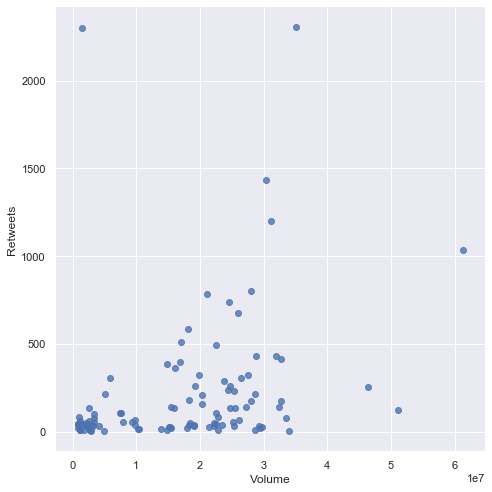

In [163]:
sns.set()
vis = sns.lmplot(data=combined_df, x='Volume', y='Retweets',  fit_reg=False, height=7 )

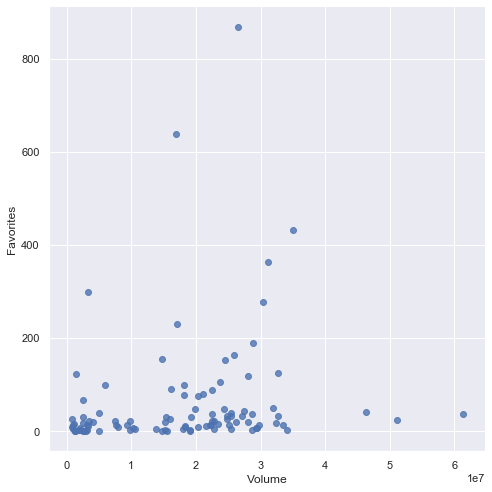

In [167]:
vis1 = sns.lmplot(data=combined_df, x='Volume', y='Favorites',  fit_reg=False, height=7 )

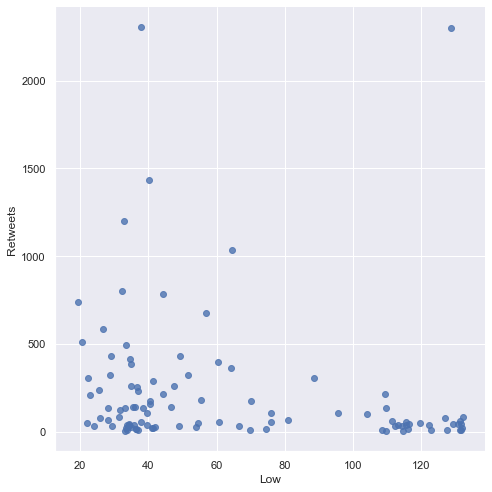

In [168]:
vis3 = sns.lmplot(data=combined_df, x='Low', y='Retweets', fit_reg=False, height=7 )

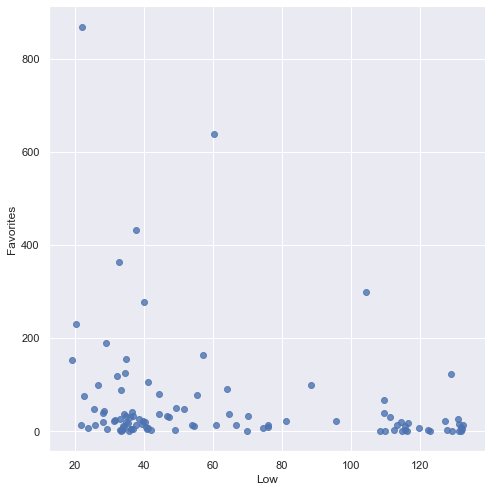

In [169]:
vis4 = sns.lmplot(data=combined_df, x='Low', y='Favorites', fit_reg=False, height=7 )

Regressions

In [159]:
#linear regression on volume
x = combined_df[['Retweets', 'Favorites']]
y = combined_df['Volume']
model = sm.OLS(y, x).fit()
predictions = model.predict(x)
model.summary()

#not in percent changes from one days volume to the next, the Durbin-Watson indicates autocorrelation

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 Volume   R-squared (uncentered):                   0.332
Model:                            OLS   Adj. R-squared (uncentered):              0.319
Method:                 Least Squares   F-statistic:                              25.09
Date:                Tue, 16 Jun 2020   Prob (F-statistic):                    1.42e-09
Time:                        17:52:17   Log-Likelihood:                         -1863.1
No. Observations:                 103   AIC:                                      3730.
Df Residuals:                     101   BIC:                                      3735.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Retweets    2.097e+04   4826.882      4.345      0.000    1.14e+04    3.05e+04
Favorites    2.93e+04   1.57e+04      1.870      0.064   -1783.922    6.04e+04
==============================================================================
Omnibus:                       20.812   Durbin-Watson:                   0.611
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.197
Skew:                          -0.665   Prob(JB):                     1.70e-12
Kurtosis:                       6.295   Cond. No.                         4.20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [160]:
#linear regression on daily low
x = combined_df[['Retweets', 'Favorites']]
y = combined_df['Low']
model = sm.OLS(y, x).fit()
predictions = model.predict(x)
model.summary()

#again since not in percent changes in daily low, the Durbin-Watson indicated autocorrelation

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    Low   R-squared (uncentered):                   0.138
Model:                            OLS   Adj. R-squared (uncentered):              0.121
Method:                 Least Squares   F-statistic:                              8.098
Date:                Tue, 16 Jun 2020   Prob (F-statistic):                    0.000547
Time:                        17:52:50   Log-Likelihood:                         -581.80
No. Observations:                 103   AIC:                                      1168.
Df Residuals:                     101   BIC:                                      1173.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Retweets       0.0506      0.019      2.647      0.009       0.013       0.088
Favorites      0.0519      0.062      0.837      0.404      -0.071       0.175
==============================================================================
Omnibus:                        0.069   Durbin-Watson:                   0.185
Prob(Omnibus):                  0.966   Jarque-Bera (JB):                0.194
Skew:                           0.052   Prob(JB):                        0.908
Kurtosis:                       2.814   Cond. No.                         4.20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""